## Imports

In [7]:
import csv
import re
import os
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import Choropleth
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, mean_squared_error, r2_score, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.regularizers import L2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import GradientBoostingClassifier
import random
from sklearn.utils import resample
from keras import backend as K
import tensorflow as tf
import datetime

random.seed(69)

In [8]:
p = Path.cwd()
data_folder = p.parent.parent / "data"
shape_folder = p.parent.parent / "shape"

## Leitura do ficheiro

In [9]:
file = data_folder / "EventosFinalComClusterConcelhos.feather"
evento = pd.read_feather(file)
evento.rename(columns = {"data_do_incidente":"date"}, inplace=True)

file = data_folder / "Diarios_sencosfixed.feather"
QuebrasFinal = pd.read_feather(file)

In [10]:
QuebrasFinal

,concelho,distrito,date,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,...,percentagem_zonaa,percentagem_zonab,percentagem_zonac,soma_degree_rede_concelho,n_subestacoes_concelho,perc_prim,perc_sec,perc_terc,minheight,maxheight
0,ALMADA,SETUBAL,2018-01-01,8.8,17.8,2.7,273.50,292.5,1.700,6.725,...,0.569832,0.351955,0.078212,17.0,7.0,0.005225,0.136672,0.858103,0.0,125.0
1,ALMADA,SETUBAL,2018-01-02,10.7,17.4,2.6,278.25,289.5,2.000,7.800,...,0.569832,0.351955,0.078212,17.0,7.0,0.005225,0.136672,0.858103,0.0,125.0
2,ALMADA,SETUBAL,2018-01-03,14.7,17.5,10.2,291.25,320.5,2.050,6.200,...,0.569832,0.351955,0.078212,17.0,7.0,0.005225,0.136672,0.858103,0.0,125.0
3,ALMADA,SETUBAL,2018-01-04,15.0,20.3,12.9,255.25,244.5,2.625,7.450,...,0.569832,0.351955,0.078212,17.0,7.0,0.005225,0.136672,0.858103,0.0,125.0
4,ALMADA,SETUBAL,2018-01-05,12.8,15.7,9.5,245.25,194.0,3.575,11.200,...,0.569832,0.351955,0.078212,17.0,7.0,0.005225,0.136672,0.858103,0.0,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560891,RESENDE,VISEU,2023-12-27,7.3,12.6,2.8,133.00,90.0,2.600,5.700,...,0.000000,0.000000,1.000000,0.0,0.0,0.170873,0.237308,0.591819,50.0,1218.0
560892,RESENDE,VISEU,2023-12-28,8.8,10.7,7.2,202.00,208.0,2.300,5.500,...,0.000000,0.000000,1.000000,0.0,0.0,0.170873,0.237308,0.591819,50.0,1218.0
560893,RESENDE,VISEU,2023-12-29,9.3,11.9,7.9,157.00,231.0,1.400,3.700,...,0.000000,0.000000,1.000000,0.0,0.0,0.170873,0.237308,0.591819,50.0,1218.0
560894,RESENDE,VISEU,2023-12-30,9.0,9.7,7.6,191.00,219.0,2.600,8.300,...,0.000000,0.000000,1.000000,0.0,0.0,0.170873,0.237308,0.591819,50.0,1218.0


In [11]:
QuebrasFinal.set_index(["concelho", 'date'], inplace=True)
evento.set_index(['concelho', 'date'], inplace=True)

QuebrasFinal["n_incidentes"] = 0

# Iterando sobre os índices do DataFrame evento e atualizando QuebrasFinal
for index in evento.index:
    # Incrementando o contador de incidentes em QuebrasFinal
    QuebrasFinal.loc[index, "n_incidentes"] += 1
QuebrasFinal = QuebrasFinal.reset_index()
QuebrasFinal

,concelho,date,distrito,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,...,percentagem_zonab,percentagem_zonac,soma_degree_rede_concelho,n_subestacoes_concelho,perc_prim,perc_sec,perc_terc,minheight,maxheight,n_incidentes
0,ALMADA,2018-01-01,SETUBAL,8.8,17.8,2.7,273.50,292.5,1.700,6.725,...,0.351955,0.078212,17.0,7.0,0.005225,0.136672,0.858103,0.0,125.0,0
1,ALMADA,2018-01-02,SETUBAL,10.7,17.4,2.6,278.25,289.5,2.000,7.800,...,0.351955,0.078212,17.0,7.0,0.005225,0.136672,0.858103,0.0,125.0,1
2,ALMADA,2018-01-03,SETUBAL,14.7,17.5,10.2,291.25,320.5,2.050,6.200,...,0.351955,0.078212,17.0,7.0,0.005225,0.136672,0.858103,0.0,125.0,0
3,ALMADA,2018-01-04,SETUBAL,15.0,20.3,12.9,255.25,244.5,2.625,7.450,...,0.351955,0.078212,17.0,7.0,0.005225,0.136672,0.858103,0.0,125.0,0
4,ALMADA,2018-01-05,SETUBAL,12.8,15.7,9.5,245.25,194.0,3.575,11.200,...,0.351955,0.078212,17.0,7.0,0.005225,0.136672,0.858103,0.0,125.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560891,RESENDE,2023-12-27,VISEU,7.3,12.6,2.8,133.00,90.0,2.600,5.700,...,0.000000,1.000000,0.0,0.0,0.170873,0.237308,0.591819,50.0,1218.0,0
560892,RESENDE,2023-12-28,VISEU,8.8,10.7,7.2,202.00,208.0,2.300,5.500,...,0.000000,1.000000,0.0,0.0,0.170873,0.237308,0.591819,50.0,1218.0,0
560893,RESENDE,2023-12-29,VISEU,9.3,11.9,7.9,157.00,231.0,1.400,3.700,...,0.000000,1.000000,0.0,0.0,0.170873,0.237308,0.591819,50.0,1218.0,0
560894,RESENDE,2023-12-30,VISEU,9.0,9.7,7.6,191.00,219.0,2.600,8.300,...,0.000000,1.000000,0.0,0.0,0.170873,0.237308,0.591819,50.0,1218.0,0


In [12]:
QuebrasFinal['n_incidentes'].unique()

array([0, 1, 3, 2, 4], dtype=int64)

## Estandardizar/Normalizar os dados

In [13]:
# Selecionar as colunas numéricas
colunas_numericas = QuebrasFinal.select_dtypes(include=[np.number]).columns
colunas_numericas = colunas_numericas.drop('n_incidentes', errors='ignore')
colunas_numericas

Index(['t_med', 't_max', 't_min', 'dd_med', 'dd_ffx', 'ff_med', 'ff_max',
       'pr_qtd', 'dd_med_sin', 'dd_med_cos', 'dd_ffx_sin', 'dd_ffx_cos',
       'sen_ano', 'cos_ano', 'sen_mes', 'cos_mes', 'densidade_populacional',
       'populacao_residente', 'setor_primario', 'setor_secundario',
       'setor_terciario', 'indice_de_envelhecimento', 'rural', 'count_zonaa',
       'count_zonab', 'count_zonac', 'total_concelho_zonas',
       'percentagem_zonaa', 'percentagem_zonab', 'percentagem_zonac',
       'soma_degree_rede_concelho', 'n_subestacoes_concelho', 'perc_prim',
       'perc_sec', 'perc_terc', 'minheight', 'maxheight'],
      dtype='object')

In [14]:
# Escolher o que queres
_ = False

if _ == True:
    # Criar o objeto do normalizador Min-Max
    scaler = MinMaxScaler()
    
    # Normalizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

else:
    # Criar o objeto do estandardizador
    scaler = StandardScaler()
    
    # Estandardizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal

,concelho,date,distrito,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,...,percentagem_zonab,percentagem_zonac,soma_degree_rede_concelho,n_subestacoes_concelho,perc_prim,perc_sec,perc_terc,minheight,maxheight,n_incidentes
0,ALMADA,2018-01-01,SETUBAL,-1.231167,-0.510624,-1.608716,0.581558,0.639467,-0.910504,-0.822632,...,0.212608,-1.621231,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,0
1,ALMADA,2018-01-02,SETUBAL,-0.890658,-0.567731,-1.628273,0.625958,0.610061,-0.694525,-0.507403,...,0.212608,-1.621231,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,1
2,ALMADA,2018-01-03,SETUBAL,-0.173798,-0.553454,-0.141953,0.747473,0.913921,-0.658529,-0.976581,...,0.212608,-1.621231,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,0
3,ALMADA,2018-01-04,SETUBAL,-0.120033,-0.153707,0.386081,0.410970,0.168973,-0.244570,-0.610036,...,0.212608,-1.621231,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,0
4,ALMADA,2018-01-05,SETUBAL,-0.514307,-0.810434,-0.278851,0.317498,-0.326025,0.439363,0.489598,...,0.212608,-1.621231,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560891,RESENDE,2023-12-27,VISEU,-1.499990,-1.253012,-1.589159,-0.731735,-1.345427,-0.262568,-1.123199,...,-0.896066,1.028931,-0.319412,-0.766372,1.528111,-0.214480,-0.797211,-0.356104,1.445499,0
560892,RESENDE,2023-12-28,VISEU,-1.231167,-1.524269,-0.728658,-0.086772,-0.188798,-0.478546,-1.181846,...,-0.896066,1.028931,-0.319412,-0.766372,1.528111,-0.214480,-0.797211,-0.356104,1.445499,0
560893,RESENDE,2023-12-29,VISEU,-1.141560,-1.352949,-0.591760,-0.507400,0.036647,-1.126482,-1.709670,...,-0.896066,1.028931,-0.319412,-0.766372,1.528111,-0.214480,-0.797211,-0.356104,1.445499,0
560894,RESENDE,2023-12-30,VISEU,-1.195324,-1.667036,-0.650431,-0.189592,-0.080976,-0.262568,-0.360786,...,-0.896066,1.028931,-0.319412,-0.766372,1.528111,-0.214480,-0.797211,-0.356104,1.445499,0


## Modelling

### Regressão

In [15]:
teste = QuebrasFinal[(QuebrasFinal["concelho"] == "LISBOA")]
teste

,concelho,date,distrito,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,...,percentagem_zonab,percentagem_zonac,soma_degree_rede_concelho,n_subestacoes_concelho,perc_prim,perc_sec,perc_terc,minheight,maxheight,n_incidentes
81067,LISBOA,2018-01-01,LISBOA,-0.657679,-0.724774,-0.552647,0.614274,0.418923,-1.054489,-0.741992,...,-0.896066,-1.846093,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,0
81068,LISBOA,2018-01-02,LISBOA,-0.478464,-0.781881,-0.357078,0.539496,0.801199,-0.838511,-0.771316,...,-0.896066,-1.846093,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,0
81069,LISBOA,2018-01-03,LISBOA,-0.209641,-0.624837,0.386081,0.679705,0.801199,-0.622532,-1.035228,...,-0.896066,-1.846093,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,0
81070,LISBOA,2018-01-04,LISBOA,-0.245484,-0.724774,0.464309,0.371244,0.360111,-0.118582,-0.478080,...,-0.896066,-1.846093,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,0
81071,LISBOA,2018-01-05,LISBOA,-0.585993,-0.896095,-0.357078,0.717094,-0.022165,0.457361,1.281335,...,-0.896066,-1.846093,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83253,LISBOA,2023-12-27,LISBOA,-1.428304,-1.681313,-1.022011,-1.376697,-1.404239,0.529354,-0.683345,...,-0.896066,-1.846093,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,0
83254,LISBOA,2023-12-28,LISBOA,-1.051952,-1.238735,-0.689545,-1.414086,-1.727703,-0.046589,-0.947257,...,-0.896066,-1.846093,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,0
83255,LISBOA,2023-12-29,LISBOA,-1.016109,-1.338672,-0.435306,-1.442128,-1.786515,-0.190575,-1.005904,...,-0.896066,-1.846093,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,0
83256,LISBOA,2023-12-30,LISBOA,-0.854815,-0.938925,-0.806886,-1.507559,-1.404239,-0.694525,-1.299140,...,-0.896066,-1.846093,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,0


In [16]:
# Selecionar apenas as colunas relevantes
features = ['t_med', 't_max', 't_min', 'ff_med', 
            'ff_max', 'pr_qtd', 'dd_med_sin', 'dd_med_cos',
       'dd_ffx_sin', 'dd_ffx_cos', 'sen_ano', 'cos_ano', 'sen_mes', 'cos_mes',
       'densidade_populacional', 'populacao_residente', 'indice_de_envelhecimento',
       'rural', 'count_zonaa', 'count_zonab', 'count_zonac',
       'total_concelho_zonas', 'soma_degree_rede_concelho',
       'n_subestacoes_concelho', 'perc_prim', 'perc_sec', 'perc_terc',
       'minheight', 'maxheight']
target = 'n_incidentes'

In [17]:
X = teste[features].values
y = teste[target].values

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados de entrada
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Calcular a proporção de classes
class_weights = len(y_train) / (2 * np.bincount(y_train.astype(int)))

# Definir a função de peso de amostra
def sample_weight_function(y):
    return class_weights[y.astype(int)]

# Construir o modelo LSTM
model = Sequential([
    LSTM(units=50, return_sequences=True, kernel_regularizer=L2(0.001), input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(units=50, kernel_regularizer=L2(0.001)),
    Dropout(0.3),
    Dense(1, kernel_regularizer=L2(0.001), activation='linear')  # Ativação linear para regressão
])

# Compilar o modelo
model.compile(optimizer=Adam(), loss='mse')

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1, sample_weight=sample_weight_function(y_train))

# Avaliar o modelo
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

Epoch 1/20


C:\Users\diogo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.0828 - val_loss: 0.7650
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5133 - val_loss: 0.6510
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1470 - val_loss: 0.3035
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6796 - val_loss: 0.3853
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3842 - val_loss: 0.5284
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1976 - val_loss: 0.7017
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8688 - val_loss: 0.7218
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1294 - val_loss: 0.5872
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0527 - val_loss: 0.6684
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9931 - val_loss: 0.6701
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2254 - val_loss: 0.5522
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2310 - val_loss: 0.6782

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
import numpy as np

# Fazer previsões com o modelo
y_pred = model.predict(X_test)

# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calcular a raiz do erro quadrático médio (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calcular o erro absoluto médio (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calcular o erro absoluto percentual médio (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# Calcular o desvio médio absoluto (MBD)
mbd = np.mean(y_pred - y_test)
print(f'Mean Bias Deviation (MBD): {mbd}')

# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R²): {r2}')

# Calcular a variância explicada
explained_variance = explained_variance_score(y_test, y_pred)
print(f'Explained Variance Score: {explained_variance}')


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean Squared Error (MSE): 0.9192745987704521
Root Mean Squared Error (RMSE): 0.958788088563084
Mean Absolute Error (MAE): 0.9136960808875078
Mean Absolute Percentage Error (MAPE): 4067414419769236.5
Mean Bias Deviation (MBD): 0.8850204715831947
R-squared (R²): -14.121502214889066
Explained Variance Score: -1.2373362458023598


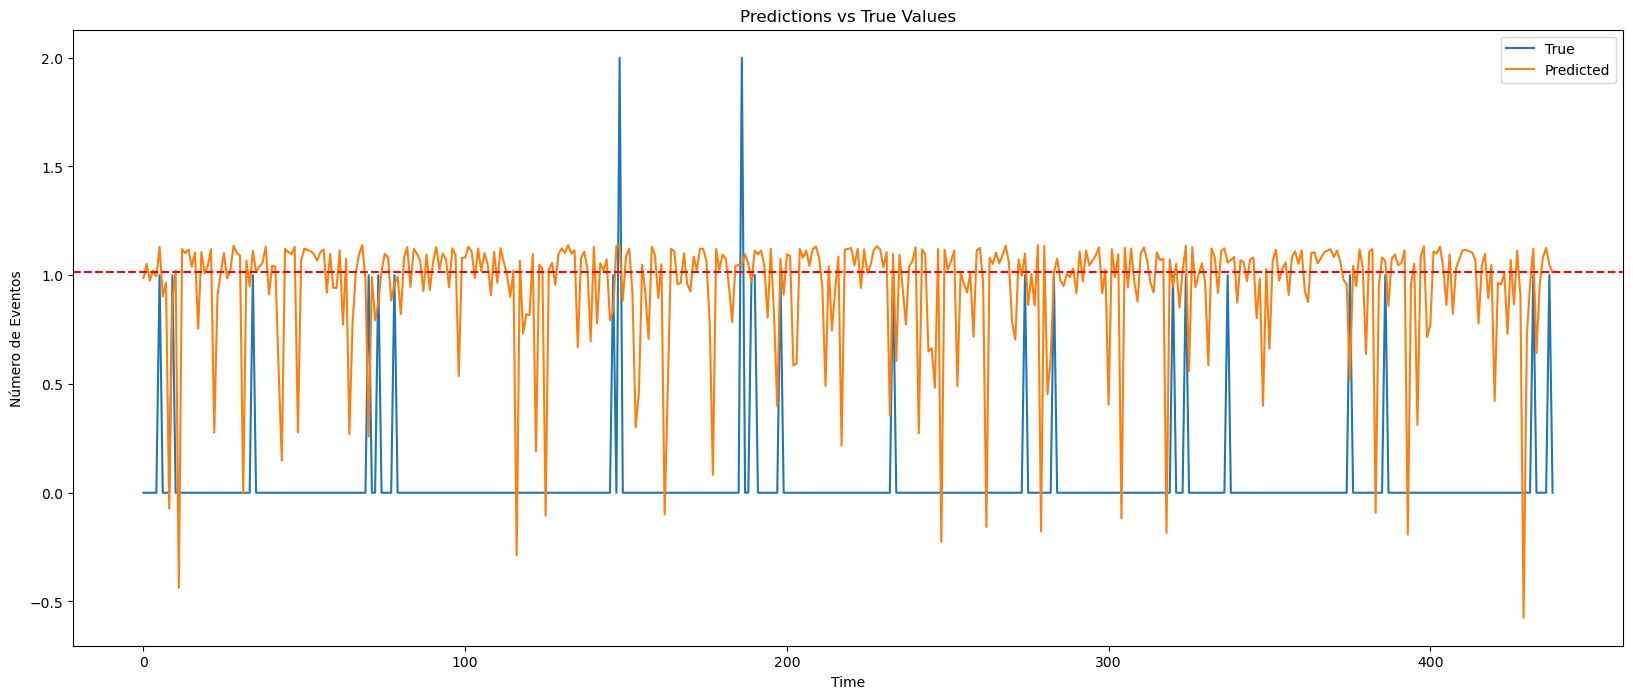

In [38]:
#### Plotar as previsões vs. os valores reais
plt.figure(figsize=(20, 8))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.axhline(y=1.015, color='r', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Número de Eventos')
plt.title('Predictions vs True Values')
plt.legend()
plt.savefig('LSTMcount')
plt.show()


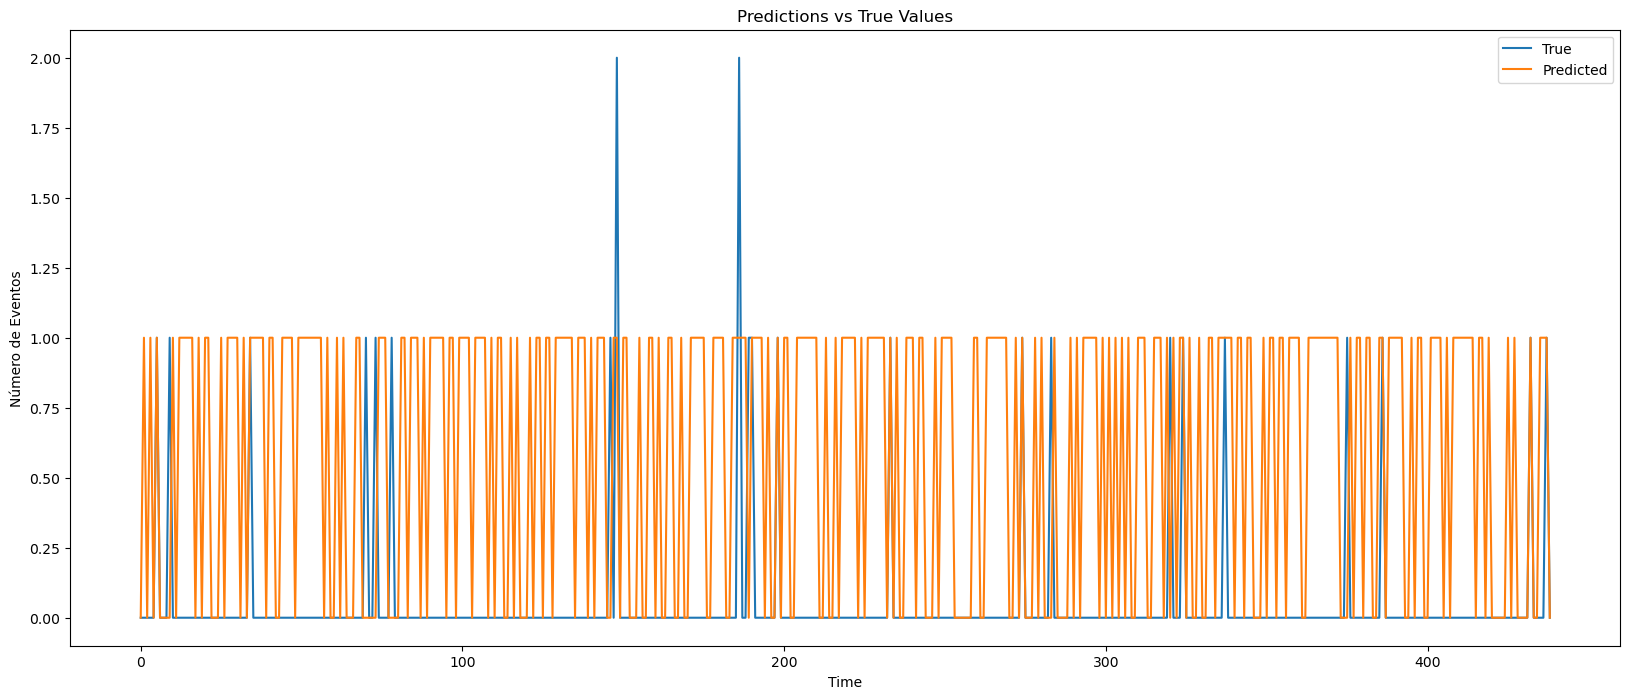

In [20]:
# Arredondar os valores de y_pred
y_pred[y_pred < 1.015] = 0
y_pred_rounded = y_pred.round()

y_test_flat = y_test.flatten()
y_pred_rounded_flat = y_pred_rounded.flatten()

# Criar um DataFrame com y_test e y_pred_rounded
df_comparison = pd.DataFrame({'True': y_test_flat, 'Predicted': y_pred_rounded_flat})

# Plotar os valores verdadeiros e previstos
plt.figure(figsize=(20, 8))
plt.plot(df_comparison['True'], label='True')
plt.plot(df_comparison['Predicted'], label='Predicted')

# Configurar os rótulos e título do gráfico
plt.xlabel('Time')
plt.ylabel('Número de Eventos')
plt.title('Predictions vs True Values')
plt.legend()

# Exibir o gráfico
plt.show()


In [40]:
mse = mean_squared_error(df_comparison['True'], df_comparison['Predicted'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(df_comparison['True'], df_comparison['Predicted'])
mape = mean_absolute_percentage_error(df_comparison['True'], df_comparison['Predicted'])
mbd = np.mean(df_comparison['Predicted'] - df_comparison['True'])
r2 = r2_score(df_comparison['True'], df_comparison['Predicted'])
explained_variance = explained_variance_score(df_comparison['True'], df_comparison['Predicted'])

# Imprimir as métricas de desempenho
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'Mean Bias Deviation (MBD): {mbd}')
print(f'R-squared (R²): {r2}')
print(f'Explained Variance Score: {explained_variance}')

Mean Squared Error (MSE): 0.5854214123006833
Root Mean Squared Error (RMSE): 0.7651283632833665
Mean Absolute Error (MAE): 0.5854214123006833
Mean Absolute Percentage Error (MAPE): 2523657194380733.5
Mean Bias Deviation (MBD): 0.5353075170842825
R-squared (R²): -8.629822465005121
Explained Variance Score: -3.9161829976101057


## Mapa com a previsão de todos os clusters (a previsão encontra-se abaixo)

In [22]:
file_path = shape_folder / "concelhos.shp"
Concelho = gpd.read_file(file_path)
Concelho.rename(columns={'NAME_1': 'Distrito'}, inplace=True)
Concelho.rename(columns={'NAME_2': 'Concelho'}, inplace=True)
Concelho["Concelho"] = Concelho["Concelho"].str.upper()

def remover_pontuacao(text):
    text = text.replace('Ç', 'C').replace('Ã', 'A').replace('É', 'E').replace('Â', 'A').replace('Ô', 'O').replace('Á', 'A').replace('Ú', 'U').replace('Ê', 'E').replace('Ó', 'O').replace('Í', 'I')
    return text

Concelho["Concelho"] = Concelho["Concelho"].apply(remover_pontuacao)
Concelho["Concelho"] = Concelho["Concelho"].str.replace('-', ' ')

Concelho = Concelho[~Concelho['Distrito'].isin(['Azores', 'Madeira'])].reset_index(drop = True)

In [23]:
PreverErrado = pd.read_csv("PreverFuturo.csv")
PreverErrado.loc[PreverErrado["Previsão"] < 1.015, "Previsão"] = 0
PreverErrado["Previsão"] = PreverErrado["Previsão"].round()
PreverErrado.reset_index(drop=True, inplace=True)
PreverErrado

,Concelho,Previsão
0,ALMADA,0.0
1,SERTA,0.0
2,FELGUEIRAS,0.0
3,TORRES VEDRAS,0.0
4,NISA,0.0
...,...,...
251,CUBA,0.0
252,MIRANDA DO DOURO,0.0
253,FIGUEIRA DE CASTELO RODRIGO,0.0
254,SERNANCELHE,0.0


In [42]:
MapaPrever = Concelho.merge(PreverErrado, on='Concelho', how='left')
MapaPrever.fillna(0, inplace=True)
MapaPrever

,ID_0,ISO,NAME_0,ID_1,Distrito,ID_2,Concelho,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry,Previsão
0,182,PRT,Portugal,1,Évora,1,EVORA,PT.EV.EV,0,0705,Concelho,Municipality,0,0,"POLYGON ((-7.79291 38.76507, -7.79287 38.76506...",0.0
1,182,PRT,Portugal,1,Évora,2,ALANDROAL,PT.EV.AL,0,0701,Concelho,Municipality,0,0,"POLYGON ((-7.25937 38.77351, -7.25921 38.77343...",0.0
2,182,PRT,Portugal,1,Évora,3,ARRAIOLOS,PT.EV.AR,0,0702,Concelho,Municipality,0,0,"POLYGON ((-7.88611 38.92495, -7.88580 38.92472...",0.0
3,182,PRT,Portugal,1,Évora,4,BORBA,PT.EV.BO,0,0703,Concelho,Municipality,0,0,"POLYGON ((-7.46362 38.92344, -7.46344 38.92329...",0.0
4,182,PRT,Portugal,1,Évora,5,ESTREMOZ,PT.EV.ES,0,0704,Concelho,Municipality,0,0,"POLYGON ((-7.52770 39.00080, -7.52765 39.00066...",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,182,PRT,Portugal,20,Viseu,302,TAROUCA,PT.VI.TR,0,1820,Concelho,Municipality,0,0,"POLYGON ((-7.72591 41.08079, -7.72442 41.08028...",0.0
274,182,PRT,Portugal,20,Viseu,303,TONDELA,PT.VI.TO,0,1821,Concelho,Municipality,0,0,"POLYGON ((-8.12772 40.64028, -8.12751 40.64027...",0.0
275,182,PRT,Portugal,20,Viseu,304,VILA NOVA DE PAIVA,PT.VI.VP,0,1822,Concelho,Municipality,0,0,"POLYGON ((-7.77933 40.93439, -7.77835 40.93436...",0.0
276,182,PRT,Portugal,20,Viseu,305,VISEU,PT.VI.VS,0,1823,Concelho,Municipality,0,0,"POLYGON ((-7.80686 40.83789, -7.80653 40.83787...",0.0


In [45]:
concelhos_com_eventos = MapaPrever[MapaPrever['Previsão'] > 0]
concelhos_com_eventos

,ID_0,ISO,NAME_0,ID_1,Distrito,ID_2,Concelho,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry,Previsão
19,182,PRT,Portugal,2,Aveiro,20,AVEIRO,PT.AV.AV,0,0105,Concelho,Municipality,0,0,"MULTIPOLYGON (((-8.68958 40.63792, -8.68958 40...",1.0
65,182,PRT,Portugal,6,Bragança,84,MACEDO DE CAVALEIROS,PT.BA.MC,0,0405,Concelho,Municipality,0,0,"POLYGON ((-7.09593 41.69820, -7.09490 41.69741...",1.0
67,182,PRT,Portugal,6,Bragança,86,MIRANDELA,PT.BA.MI,0,0407,Concelho,Municipality,0,0,"POLYGON ((-7.18368 41.73059, -7.18357 41.73053...",1.0
75,182,PRT,Portugal,7,Castelo Branco,94,COVILHA,PT.CB.CO,0,0503,Concelho,Municipality,0,0,"POLYGON ((-7.45985 40.40102, -7.45769 40.40005...",2.0
114,182,PRT,Portugal,9,Faro,132,SILVES,PT.FA.SI,0,0813,Concelho,Municipality,0,0,"POLYGON ((-8.31367 37.43610, -8.31378 37.43516...",1.0
140,182,PRT,Portugal,11,Leiria,158,LEIRIA,PT.LE.LE,0,1009,Concelho,Municipality,0,0,"POLYGON ((-8.88918 39.94897, -8.87677 39.94180...",1.0
153,182,PRT,Portugal,12,Lisboa,171,LISBOA,PT.LI.LI,0,1106,Concelho,Municipality,0,0,"MULTIPOLYGON (((-9.14490 38.70501, -9.14485 38...",1.0
186,182,PRT,Portugal,15,Porto,215,POVOA DE VARZIM,PT.PO.PV,0,1313,Concelho,Municipality,0,0,"POLYGON ((-8.75817 41.46694, -8.75257 41.46614...",1.0
198,182,PRT,Portugal,16,Santarém,227,ALMEIRIM,PT.SA.AM,0,1403,Concelho,Municipality,0,0,"POLYGON ((-8.62334 39.23027, -8.62329 39.23026...",2.0
204,182,PRT,Portugal,16,Santarém,233,CORUCHE,PT.SA.CR,0,1409,Concelho,Municipality,0,0,"POLYGON ((-8.50304 39.10907, -8.50265 39.10840...",1.0


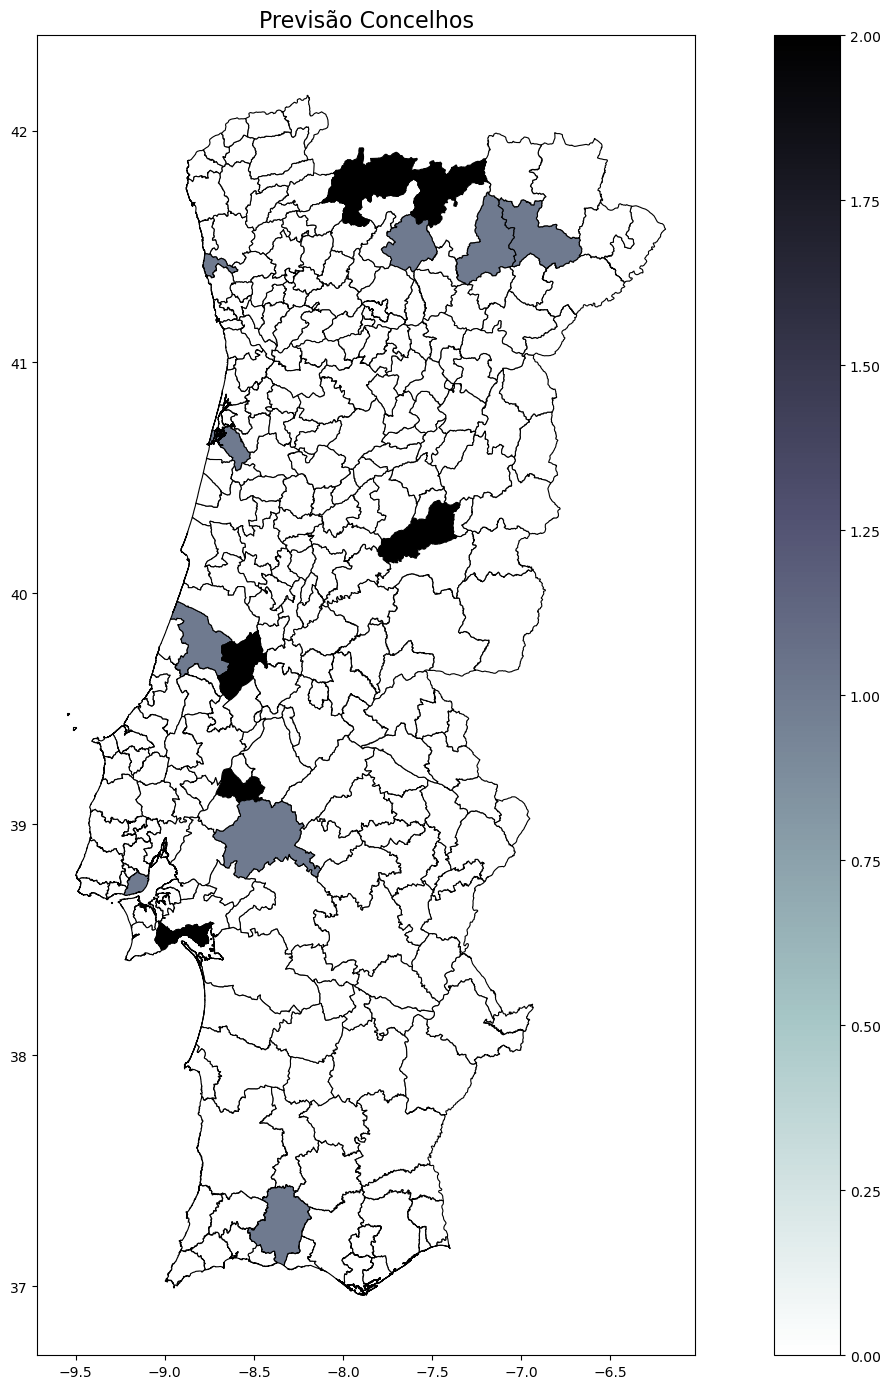

In [43]:
# Configurar a figura e os eixos para os mapas
fig, ax = plt.subplots(figsize=(16, 14))

# Plotar o mapa das freguesias
MapaPrever.plot(column="Previsão", cmap='bone_r', linewidth=0.8, edgecolor='black', legend=True, ax=ax)

# Adicionar título
ax.set_title('Previsão Concelhos', fontsize=16)

# Ajustar o layout
plt.tight_layout()
plt.show()


In [174]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

### Previsão do número de quebras energéticas

In [150]:
def train_and_predict_global(QuebrasFinal, features, target, dados_amanha, concelho_especifico):
    # Filtrar os dados para o concelho específico
    df_concelho = QuebrasFinal[QuebrasFinal['concelho'] == concelho_especifico]
    
    # Adicionar os dados de amanhã ao conjunto de dados para garantir normalização consistente
    df_completo = pd.concat([df_concelho, dados_amanha], ignore_index=True)
    
    # Separar os dados em características (X) e alvo (y)
    X = df_completo[features].values
    y = df_completo[target].values
    
    # # Normalizar os dados de entrada
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Separar os dados normalizados de amanhã
    X_amanha = X[-1].reshape(1, len(features), 1)  # Mantendo formato 3D para LSTM
    X = X[:-1].reshape((X.shape[0]-1, len(features), 1))  # Mantendo formato 3D para LSTM
    y = y[:-1]  # Remover o último valor de y, que corresponde aos dados de amanhã
    
    # Construir o modelo LSTM
    model = Sequential([
        LSTM(units=50, return_sequences=True, kernel_regularizer=L2(0.001), input_shape=(X.shape[1], 1)),
        Dropout(0.3),
        LSTM(units=50, kernel_regularizer=L2(0.001)),
        Dropout(0.3),
        Dense(1, kernel_regularizer=L2(0.001), activation='linear')
    ])
    
    # Compilar o modelo
    model.compile(optimizer=Adam(), loss='mse')
    
    # Treinar o modelo com todos os dados
    model.fit(X, y, epochs=20, batch_size=32, verbose=1)
    
    # Fazer a previsão para o próximo dia
    previsao = model.predict(X_amanha)
    
    return previsao[0][0]

In [151]:
QuebrasFinal['ano'] = QuebrasFinal['date'].dt.year
QuebrasFinal['mes'] = QuebrasFinal['date'].dt.month
QuebrasFinal['dia'] = QuebrasFinal['date'].dt.day

In [171]:
PreverFuturo

,Concelho,Previsão
0,ALMADA,5.374180e-01
1,SERTA,7.132948e-01
2,FELGUEIRAS,4.444240e-01
3,TORRES VEDRAS,5.578477e-01
4,NISA,1.256406e-01
...,...,...
251,CUBA,2.449421e-01
252,MIRANDA DO DOURO,6.529945e-09
253,FIGUEIRA DE CASTELO RODRIGO,2.296841e-01
254,SERNANCELHE,5.842347e-01


In [173]:
PreverFuturo.to_csv("PreverFuturo.csv", index=False)

### Classificação

In [14]:
# Construir o modelo LSTM
model = Sequential([
    LSTM(units=50, return_sequences=True, kernel_regularizer=L2(0.001), input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(units=50, kernel_regularizer=L2(0.001)),
    Dropout(0.3),
    Dense(5, kernel_regularizer=L2(0.001), activation='softmax')  # Softmax activation for multiclass classification
])

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy', 'sparse_categorical_crossentropy'])

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1, sample_weight=sample_weight_function(y_train))

# Avaliar o modelo
loss, accuracy, crossentropy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')
print(f'Test Crossentropy: {crossentropy}')

Epoch 1/20


C:\Users\diogo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7356 - loss: 3.2070 - sparse_categorical_crossentropy: 1.5472 - val_accuracy: 0.9630 - val_loss: 0.8221 - val_sparse_categorical_crossentropy: 0.5798
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5601 - loss: 3.5645 - sparse_categorical_crossentropy: 0.8124 - val_accuracy: 0.0370 - val_loss: 1.0000 - val_sparse_categorical_crossentropy: 1.0505
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3337 - loss: 1.7016 - sparse_categorical_crossentropy: 1.0804 - val_accuracy: 0.0000e+00 - val_loss: 1.1592 - val_sparse_categorical_crossentropy: 1.1251
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3526 - loss: 1.8941 - sparse_categorical_crossentropy: 1.1230 - val_accuracy: 0.0000e+00 - val_loss: 1.1788 - val_sparse_categorical_crossentropy: 1.1958
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2631 - loss: 2.1180 - sparse_categorical_crossentropy: 1.2022 - val_accuracy: 0.00

In [15]:
# Fazer previsões com o modelo
y_pred = model.predict(X_test)

# Arredondar as previsões para obter as classes previstas
y_pred_classes = np.argmax(y_pred, axis=1)

# Imprimir o relatório de classificação
print(classification_report(y_test, y_pred_classes))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       417
           1       0.00      0.00      0.00        20
           2       0.00      1.00      0.01         2

    accuracy                           0.00       439
   macro avg       0.00      0.33      0.00       439
weighted avg       0.00      0.00      0.00       439



C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


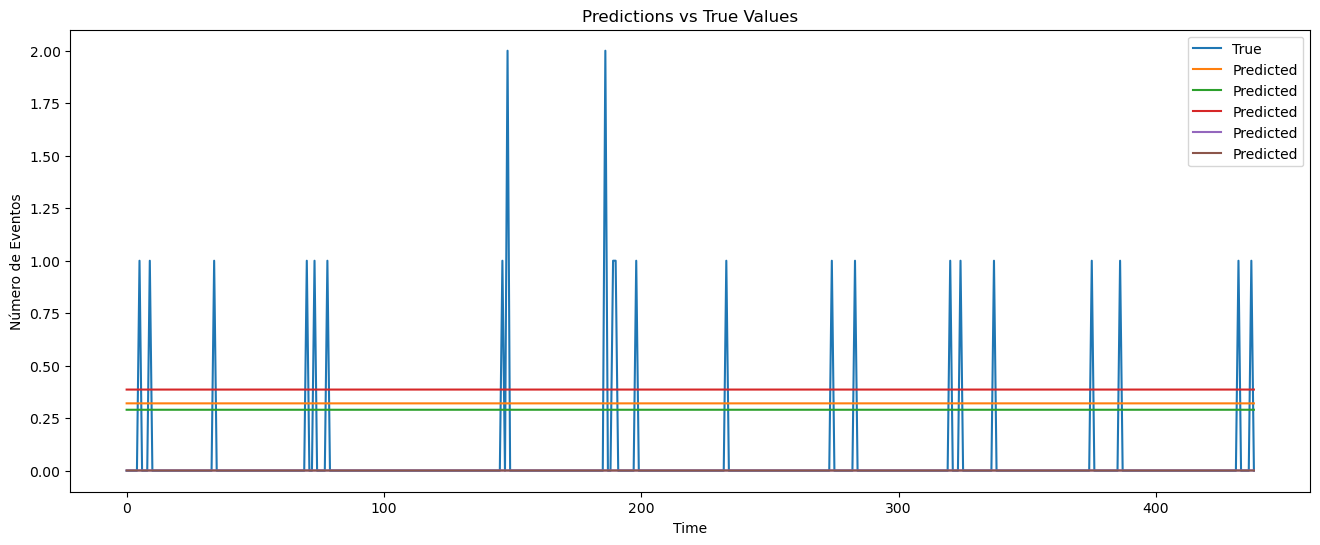

In [16]:
#### Plotar as previsões vs. os valores reais
plt.figure(figsize=(16, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Número de Eventos')
plt.title('Predictions vs True Values')
plt.legend()
plt.savefig('LSTMcount')
plt.show()


### Classificação

In [17]:
def tornarBinario(x):
    if x > 0:
        return 1
    else:
        return 0

QuebrasFinal["houve_acidentes"] = QuebrasFinal["n_incidentes"].apply(tornarBinario)
QuebrasFinal

,concelho,date,distrito,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,...,percentagem_zonac,soma_degree_rede_concelho,n_subestacoes_concelho,perc_prim,perc_sec,perc_terc,minheight,maxheight,n_incidentes,houve_acidentes
0,ALMADA,2018-01-01,SETUBAL,-1.231167,-0.510624,-1.608716,0.581558,0.639467,-0.910504,-0.822632,...,-1.621231,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,0,0
1,ALMADA,2018-01-02,SETUBAL,-0.890658,-0.567731,-1.628273,0.625958,0.610061,-0.694525,-0.507403,...,-1.621231,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,1,1
2,ALMADA,2018-01-03,SETUBAL,-0.173798,-0.553454,-0.141953,0.747473,0.913921,-0.658529,-0.976581,...,-1.621231,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,0,0
3,ALMADA,2018-01-04,SETUBAL,-0.120033,-0.153707,0.386081,0.410970,0.168973,-0.244570,-0.610036,...,-1.621231,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,0,0
4,ALMADA,2018-01-05,SETUBAL,-0.514307,-0.810434,-0.278851,0.317498,-0.326025,0.439363,0.489598,...,-1.621231,1.444650,2.258602,-1.010226,-1.177012,1.949118,-0.793629,-1.231605,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560891,RESENDE,2023-12-27,VISEU,-1.499990,-1.253012,-1.589159,-0.731735,-1.345427,-0.262568,-1.123199,...,1.028931,-0.319412,-0.766372,1.528111,-0.214480,-0.797211,-0.356104,1.445499,0,0
560892,RESENDE,2023-12-28,VISEU,-1.231167,-1.524269,-0.728658,-0.086772,-0.188798,-0.478546,-1.181846,...,1.028931,-0.319412,-0.766372,1.528111,-0.214480,-0.797211,-0.356104,1.445499,0,0
560893,RESENDE,2023-12-29,VISEU,-1.141560,-1.352949,-0.591760,-0.507400,0.036647,-1.126482,-1.709670,...,1.028931,-0.319412,-0.766372,1.528111,-0.214480,-0.797211,-0.356104,1.445499,0,0
560894,RESENDE,2023-12-30,VISEU,-1.195324,-1.667036,-0.650431,-0.189592,-0.080976,-0.262568,-0.360786,...,1.028931,-0.319412,-0.766372,1.528111,-0.214480,-0.797211,-0.356104,1.445499,0,0


In [18]:
teste = QuebrasFinal[QuebrasFinal["concelho"] == "LISBOA"]
teste

,concelho,date,distrito,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,...,percentagem_zonac,soma_degree_rede_concelho,n_subestacoes_concelho,perc_prim,perc_sec,perc_terc,minheight,maxheight,n_incidentes,houve_acidentes
81067,LISBOA,2018-01-01,LISBOA,-0.657679,-0.724774,-0.552647,0.614274,0.418923,-1.054489,-0.741992,...,-1.846093,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,0,0
81068,LISBOA,2018-01-02,LISBOA,-0.478464,-0.781881,-0.357078,0.539496,0.801199,-0.838511,-0.771316,...,-1.846093,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,0,0
81069,LISBOA,2018-01-03,LISBOA,-0.209641,-0.624837,0.386081,0.679705,0.801199,-0.622532,-1.035228,...,-1.846093,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,0,0
81070,LISBOA,2018-01-04,LISBOA,-0.245484,-0.724774,0.464309,0.371244,0.360111,-0.118582,-0.478080,...,-1.846093,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,0,0
81071,LISBOA,2018-01-05,LISBOA,-0.585993,-0.896095,-0.357078,0.717094,-0.022165,0.457361,1.281335,...,-1.846093,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83253,LISBOA,2023-12-27,LISBOA,-1.428304,-1.681313,-1.022011,-1.376697,-1.404239,0.529354,-0.683345,...,-1.846093,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,0,0
83254,LISBOA,2023-12-28,LISBOA,-1.051952,-1.238735,-0.689545,-1.414086,-1.727703,-0.046589,-0.947257,...,-1.846093,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,0,0
83255,LISBOA,2023-12-29,LISBOA,-1.016109,-1.338672,-0.435306,-1.442128,-1.786515,-0.190575,-1.005904,...,-1.846093,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,0,0
83256,LISBOA,2023-12-30,LISBOA,-0.854815,-0.938925,-0.806886,-1.507559,-1.404239,-0.694525,-1.299140,...,-1.846093,13.170472,10.469244,-1.011667,-1.630783,2.439396,-0.793629,-0.979325,0,0


In [19]:
# Selecionar apenas as colunas relevantes
features = ['t_med', 't_max', 't_min', 'dd_med',
       'dd_ffx', 'ff_med', 'ff_max', 'pr_qtd', 'dd_med_sin', 'dd_med_cos',
       'dd_ffx_sin', 'dd_ffx_cos', 'sen_ano', 'cos_ano', 'sen_mes', 'cos_mes',
       'densidade_populacional', 'populacao_residente', 'indice_de_envelhecimento',
       'rural', 'count_zonaa', 'count_zonab', 'count_zonac',
       'total_concelho_zonas', 'soma_degree_rede_concelho',
       'n_subestacoes_concelho', 'perc_prim', 'perc_sec', 'perc_terc',
       'minheight', 'maxheight']
target = 'houve_acidentes'

In [46]:
X = teste[features].values
y = teste[target].values

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados de entrada
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape dos dados para o formato adequado para LSTM (3D)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Construir o modelo LSTM
model = Sequential([
    LSTM(units=50, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Avaliar o modelo
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Epoch 1/10


C:\Users\diogo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9031 - loss: 0.5499 - val_accuracy: 0.9630 - val_loss: 0.1583
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9559 - loss: 0.1880 - val_accuracy: 0.9630 - val_loss: 0.1587
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9605 - loss: 0.1711 - val_accuracy: 0.9630 - val_loss: 0.1595
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9477 - loss: 0.2061 - val_accuracy: 0.9630 - val_loss: 0.1585
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9569 - loss: 0.1804 - val_accuracy: 0.9630 - val_loss: 0.1587
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9617 - loss: 0.1644 - val_accuracy: 0.9630 - val_loss: 0.1648
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9603 - loss: 0.1703 - val_accuracy: 0.9630 - val_loss: 0.1668
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9518 - loss: 0.1965 - val_accuracy: 0.9630 - val_loss: 0.1582
Epo

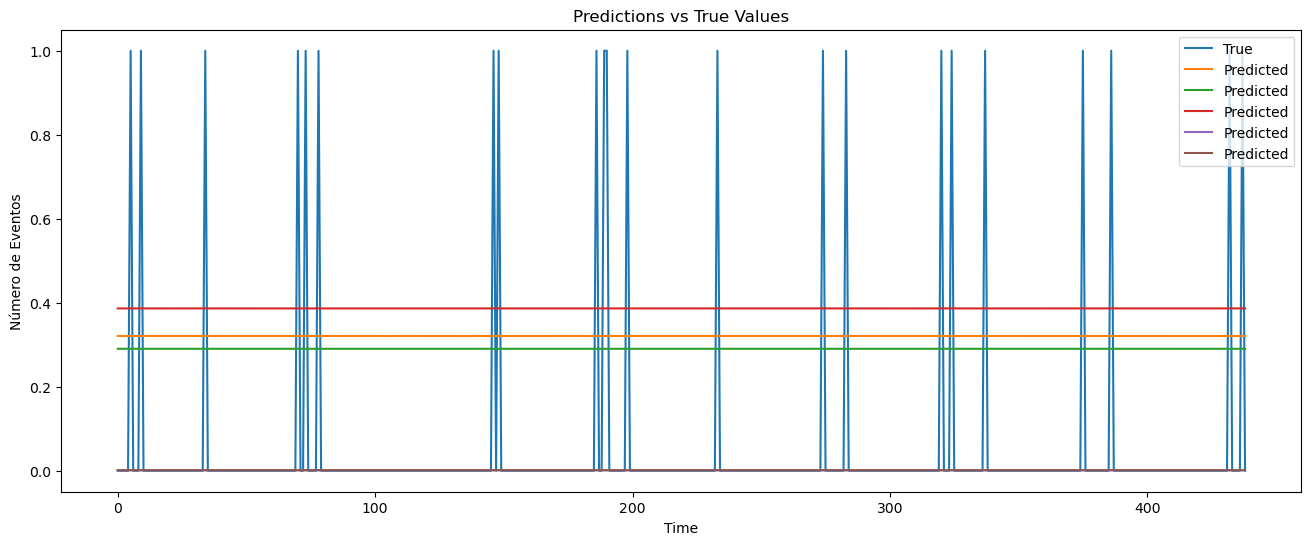

In [47]:
#### Plotar as previsões vs. os valores reais
plt.figure(figsize=(16, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Número de Eventos')
plt.title('Predictions vs True Values')
plt.legend()
plt.savefig('LSTMcount')
plt.show()

In [51]:
y_pred

array([[0.32085314, 0.29029945, 0.3864231 , 0.00132976, 0.00109455],
       [0.32077336, 0.29031703, 0.38648397, 0.00133095, 0.00109481],
       [0.3207409 , 0.29034063, 0.3864931 , 0.00133091, 0.00109459],
       ...,
       [0.3207767 , 0.29032412, 0.38647288, 0.00133124, 0.00109504],
       [0.32087466, 0.29031134, 0.38639095, 0.00132889, 0.00109414],
       [0.32074594, 0.29033342, 0.3864951 , 0.00133089, 0.0010946 ]],
      dtype=float32)